Test Loss: 65835.4912


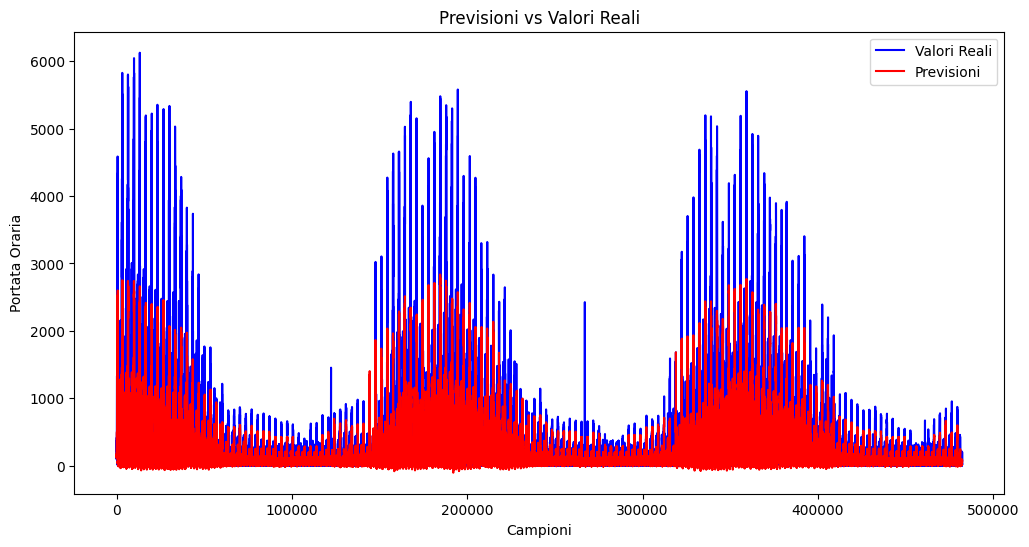

Target shape: (482310,)
Predicted shape: (482310, 1)


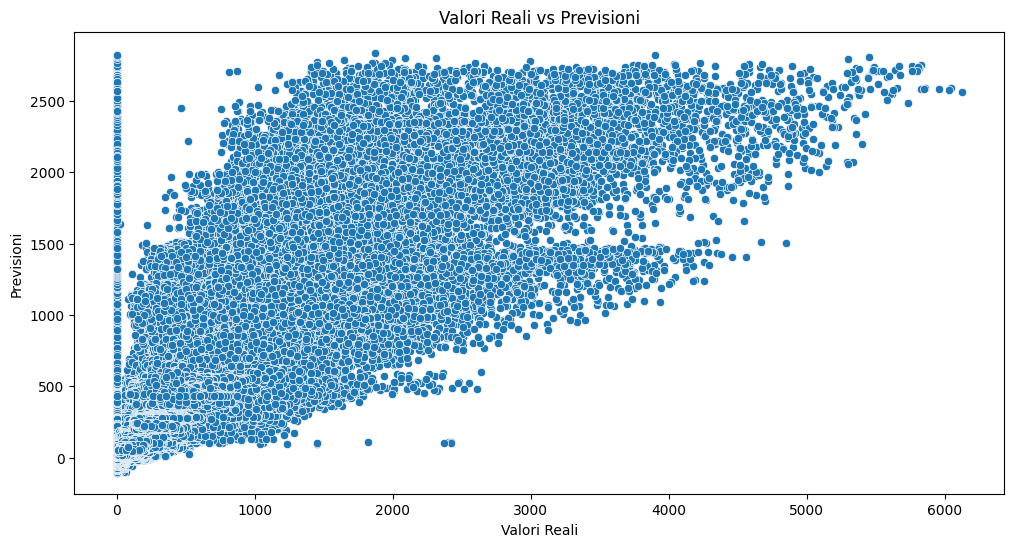

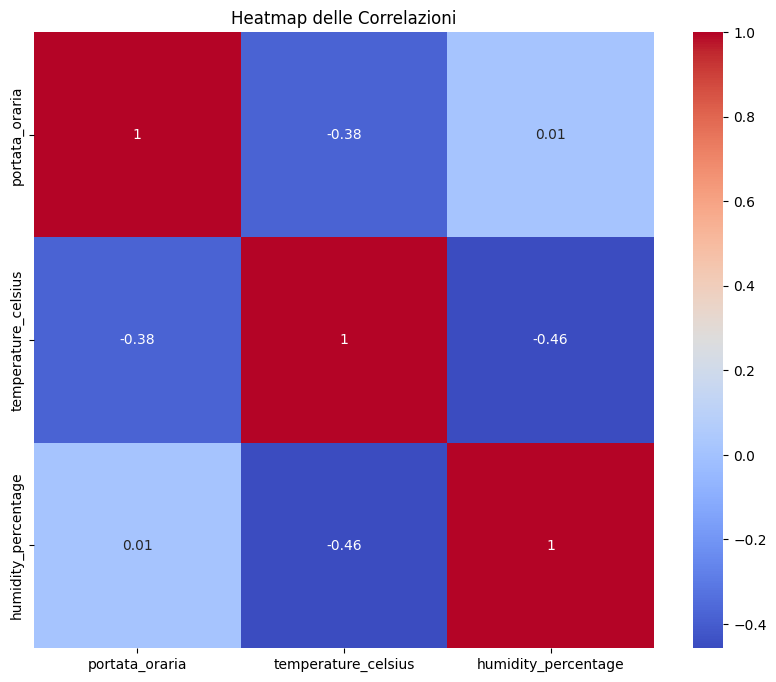

In [31]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sqlalchemy import create_engine
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

# Configura la connessione al database
db_user = 'timescale'
db_password = '7qWCJhnIGAjZEbqB'
db_host = '188.245.188.140'
db_name = 'timescale'

# Crea la connessione al database
engine = create_engine(f'postgresql://{db_user}:{db_password}@{db_host}/{db_name}')

# Esegui una query per ottenere i dati
query = """
    SELECT
        plant_id,
        EXTRACT(MONTH FROM timestamp) AS mese,
        EXTRACT(DAY FROM timestamp) AS giorno,
        EXTRACT(HOUR FROM timestamp) AS ora,
        flow AS portata_oraria,
        temperature_celsius,
        humidity_percentage
    FROM
        dataset_raw
"""
df = pd.read_sql(query, engine)

# Trasformazioni iniziali
df.columns = df.columns.str.lower()  # Rende i nomi delle colonne minuscoli
df['giorno'] = df['giorno'].astype(int)
df['mese'] = df['mese'].astype(int)
df['ora'] = df['ora'].astype(int)

# Crea una colonna datetime
valid_days_in_month = df['mese'].apply(lambda x: 31 if x in [1, 3, 5, 7, 8, 10, 12] else (30 if x in [4, 6, 9, 11] else 28))
df['valid_date'] = (df['giorno'] <= valid_days_in_month)
df = df[df['valid_date']]
df['datetime'] = pd.to_datetime(df['giorno'].astype(str) + '-' + df['mese'].astype(str) + '-' + df['ora'].astype(str) + ':00', format='%d-%m-%H:%M')
df.set_index('datetime', inplace=True)
df.drop(columns=['ora', 'giorno', 'valid_date'], inplace=True)

# Codifica One-Hot per il plant_id e mese
encoder = OneHotEncoder(sparse_output=False)
combined = df[['plant_id', 'mese']]
encoded = encoder.fit_transform(combined)

# Crea un DataFrame delle variabili categoriali
encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(['plant_id', 'mese']))
df = pd.concat([df.reset_index(drop=True), encoded_df], axis=1)

# Normalizzazione delle feature numeriche
scaler = StandardScaler()
features = df[['temperature_celsius', 'humidity_percentage']]
scaled_features = scaler.fit_transform(features)

# Obiettivo
target = df['portata_oraria'].values

# Crea un Dataset personalizzato
class TimeSeriesDataset(Dataset):
    def __init__(self, features, target):
        self.features = features
        self.target = target

    def __len__(self):
        return len(self.target)

    def __getitem__(self, idx):
        return (torch.tensor(self.features[idx], dtype=torch.float32),
                torch.tensor(self.target[idx], dtype=torch.float32))

# Calcola il numero di feature
num_features = scaled_features.shape[1] + encoded.shape[1]  # Due feature più le caratteristiche codificate
dataset = TimeSeriesDataset(np.concatenate((scaled_features, encoded), axis=1), target)

# Crea i DataLoader
train_dataset, test_dataset = train_test_split(dataset, test_size=0.2, random_state=42)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

class SimpleCNN(nn.Module):
    def __init__(self, num_features):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=2)
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=2)
        self.fc1 = nn.Linear(32 * ((num_features - 2 + 1) // 2 - 2 + 1), 64)
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        x = x.unsqueeze(1)  # Aggiungi una dimensione per i canali
        x = nn.ReLU()(self.conv1(x))  # Passaggio attraverso il primo layer convoluzionale
        x = nn.MaxPool1d(kernel_size=2)(x)  # Pooling
        x = nn.ReLU()(self.conv2(x))  # Passaggio attraverso il secondo layer convoluzionale
        x = x.view(x.size(0), -1)  # Appiattisci
        x = nn.ReLU()(self.fc1(x))  # Passaggio nel primo layer fully connected
        x = self.fc2(x)  # Output finale
        return x

# Inizializza il modello, la loss e l'ottimizzatore
model = SimpleCNN(num_features)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Ciclo di addestramento
num_epochs = 3
for epoch in range(num_epochs):
    for inputs, targets in train_dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), targets)
        loss.backward()
        optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Valutazione del modello
model.eval()  # Imposta il modello in modalità di valutazione
with torch.no_grad():
    total_loss = 0
    for inputs, targets in test_dataloader:
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), targets)
        total_loss += loss.item()

print(f'Test Loss: {total_loss / len(test_dataloader):.4f}')

# Visualizzazione dei risultati
model.eval()
with torch.no_grad():
    predicted = model(torch.tensor(np.concatenate((scaled_features, encoded), axis=1), dtype=torch.float32)).numpy()

# Visualizza i risultati
plt.figure(figsize=(12, 6))
plt.plot(target, label='Valori Reali', color='blue')
plt.plot(predicted, label='Previsioni', color='red')
plt.title('Previsioni vs Valori Reali')
plt.xlabel('Campioni')
plt.ylabel('Portata Oraria')
plt.legend()
plt.show()
# Assicurati che 'target' e 'predicted' siano unidimensionali
print("Target shape:", target.shape)
print("Predicted shape:", predicted.shape)

# Assicurati che 'predicted' sia un array unidimensionale
predicted = predicted.ravel()  # Oppure predicted.flatten()

# Se 'target' è un DataFrame o una Serie di Pandas, converti in un array NumPy unidimensionale
target = np.array(target).ravel()  # Rende target unidimensionale

# Visualizzazione delle predizioni
plt.figure(figsize=(12, 6))
sns.scatterplot(x=target, y=predicted)
plt.xlabel('Valori Reali')
plt.ylabel('Previsioni')
plt.title('Valori Reali vs Previsioni')
plt.show()

# Heatmap delle correlazioni
plt.figure(figsize=(10, 8))
sns.heatmap(df[['portata_oraria', 'temperature_celsius', 'humidity_percentage']].corr(), annot=True, cmap='coolwarm')
plt.title('Heatmap delle Correlazioni')
plt.show()


mese: 0
anno: 0
portata_oraria: 0
temperature_celsius: 0
humidity_percentage: 0


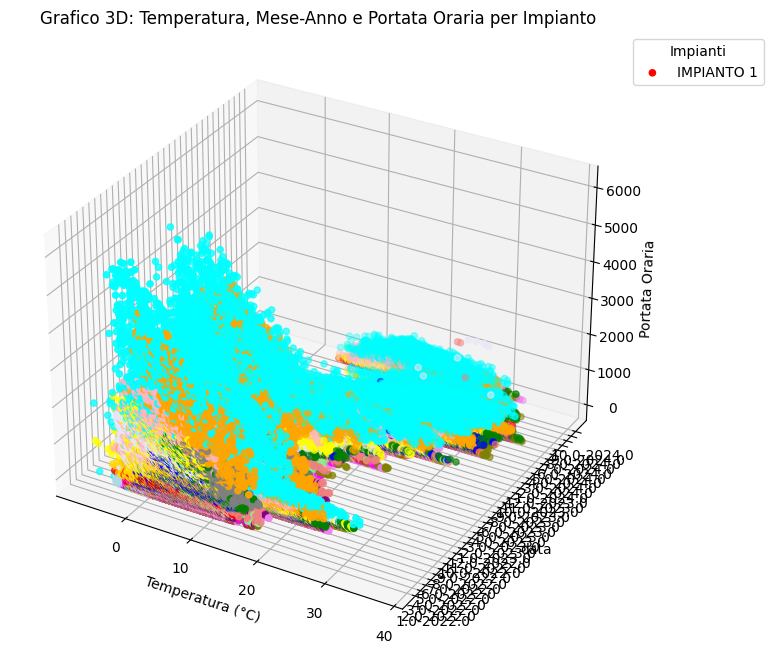

In [61]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sqlalchemy import create_engine
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D  # Importa il modulo per grafici 3D
import warnings

warnings.filterwarnings('ignore')

# Configura la connessione al database
db_user = 'timescale'
db_password = '7qWCJhnIGAjZEbqB'
db_host = '188.245.188.140'
db_name = 'timescale'

# Crea la connessione al database
engine = create_engine(f'postgresql://{db_user}:{db_password}@{db_host}/{db_name}')

# Esegui una query per ottenere i dati
query = """
    SELECT
        plant_id,
          EXTRACT(MONTH FROM timestamp) as mese,
        EXTRACT(YEAR FROM timestamp) as anno,
        flow AS portata_oraria,
        temperature_celsius,
        humidity_percentage
    FROM
        dataset_raw
"""
df = pd.read_sql(query, engine)

# Trasformazioni iniziali
df.columns = df.columns.str.lower()  # Rende i nomi delle colonne minuscoli

# Controlla la presenza di NaN e infiniti
#print("Controllo valori NaN e infiniti:")
#print("Valori NaN per colonna:\n", df.isna().sum())

# Controllo valori infiniti solo per colonne numeriche
#print("Valori infiniti per colonna (numeriche):")
numeric_cols = df.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    print(f"{col}: {np.isinf(df[col]).sum()}")

# Rimuovi righe con valori NaN
df.dropna(inplace=True)

# Rimuovi righe con valori infiniti
df = df[np.isfinite(df['portata_oraria']) & np.isfinite(df['temperature_celsius'])]

# Crea un DataFrame con i dati necessari per il grafico
data_for_plot = df[['plant_id', 'mese', 'anno', 'temperature_celsius', 'portata_oraria']]

# Controlla quali plant_id sono presenti
unique_plants = data_for_plot['plant_id'].unique()
#print("Plant IDs trovati nel DataFrame:", unique_plants)

# Aggiungi colori per i plant_id non presenti
colors = {
    'IMPIANTO 1': 'red',
    'IMPIANTO 2': 'green',
    'IMPIANTO 3': 'blue',
    'IMPIANTO 4': 'orange',
    'IMPIANTO 5': 'cyan',
    'IMPIANTO 6': 'magenta',
    'IMPIANTO 7': 'yellow',
    'IMPIANTO 8': 'purple',
    'IMPIANTO 9': 'brown',
    'IMPIANTO 10': 'pink',
    'IMPIANTO 11': 'gray',
    'IMPIANTO 12': 'lightblue',
    'IMPIANTO 13': 'lightgreen',
    'IMPIANTO 14': 'lightcoral',
    'IMPIANTO 15': 'salmon',
    'IMPIANTO 16': 'lavender',
    'IMPIANTO 17': 'gold',
    'IMPIANTO 18': 'lightpink',
    'IMPIANTO 19': 'violet',
    'IMPIANTO 20': 'olive',
}

# Aggiungi un colore predefinito per i plant_id non mappati
data_for_plot['color'] = data_for_plot['plant_id'].map(colors).fillna('gray')  # Usa 'gray' come colore di default

# Crea il grafico 3D
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Assicurati che non ci siano valori non finiti prima di creare il grafico
if data_for_plot.isnull().values.any() or not np.isfinite(data_for_plot[['temperature_celsius', 'mese','anno', 'portata_oraria']]).all().all():
    print("Ci sono valori non finiti o NaN nei dati da tracciare.")
else:
    # Converti mese e anno in un formato stringa per l'asse y
    data_for_plot['data'] = data_for_plot['mese'].astype(str) + '-' + data_for_plot['anno'].astype(str)
    # Converti il mese-anno in valori numerici per il grafico
    data_for_plot['data_numeric'] = data_for_plot['data'].astype('category').cat.codes

    # Crea il grafico
    ax.scatter(data_for_plot['temperature_celsius'],
               data_for_plot['data_numeric'],  # Utilizza la nuova colonna data
               data_for_plot['portata_oraria'],
               c=data_for_plot['color'])

    ax.set_xlabel('Temperatura (°C)')
    ax.set_ylabel('data')
    ax.set_zlabel('Portata Oraria')
    ax.set_title('Grafico 3D: Temperatura, Mese-Anno e Portata Oraria per Impianto')

   # Aggiungi una legenda
    unique_plant_ids = data_for_plot['plant_id'].unique()
    unique_colors = [colors[pid] for pid in unique_plant_ids]
    ax.legend(unique_plant_ids, title="Impianti", loc='upper left', bbox_to_anchor=(1, 1))

    # Personalizza l'asse Y per visualizzare il formato 'MM-yyyy'
    ticks = np.unique(data_for_plot['data_numeric'])
    ax.set_yticks(ticks)
    ax.set_yticklabels(data_for_plot['data'].unique()[ticks])

    plt.show()






